## CONTEXTO

Este estudo de caso tem como objetivo construir um modelo de regressão para prever o preço de imóveis com base em características como área, número de quartos, mobília e proximidade da via principal. Apesar do conjunto de dados ser pequeno, o desafio está na forte multicolinearidade entre as variáveis, que pode afetar a precisão e interpretação do modelo. O foco será explorar os dados, identificar e tratar essa multicolinearidade, e desenvolver um modelo preditivo eficiente e interpretável.

In [1]:
# Carregando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import networkx as nx
import matplotlib.cm as cm
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.optimize import curve_fit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../src')
from utils import iqr
from utils import shapiro_test, objective , breusch_pagan_test
from model import modelo_reg

In [2]:
# Importando os dados
df_housing = pd.read_csv('../Data/raw/Housing.csv')

In [3]:
df_housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df_housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

## Dicionario de dados 

| Variável               | Tradução      | Descrição                                      |
|------------------------|-------------|------------------------------------------------|
| price                   | Preço    | Preço das Casas       |
| area               | área   | área da casa                          |
| bedrooms              | quartos  | Quantidade de quartos    |
| bathrooms | banheiros  | Quantidade de banheiros |
| stories                | Andares   | Número de Andares                |
| mainroad                | Estrada Principal    | Casa conectada a uma estrada principal ?                |
| guestroom                | Quarto de Hóspedes    | Possui quarto de hóspedes ?                |
| basement                | Porão   | Possui porão ?                |
| hotwaterheating                | Aquecedor de água quente    | Possui aquecedor de água quente ?                |
| airconditioning                | Ar condicionado    | Possui ar condicionado ?                 |
| parking                | Estacionamento    | Número de vagas de estacionamento              |
| prefarea                | Área Valorizada ?    | Indica se o imóvel está localizado em área valorizada ou desejada                |
| furnishingstatus                | Situação mobiliaria da casa  | Está monbiliada ?             |

In [5]:
# Verificando o tamanho do DataFrame
df_housing.shape


(545, 13)

In [6]:
# Verificando os tipos das variáveis
df_housing.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [7]:
# Verificando a existência de dados ausentes
df_housing.isnull().sum()/len(df_housing)*100

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [8]:
df_housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


Como o principal foco deste estudo é a variável price - preço das residências, a análise exploratória será direcionada especialmente a ela. A partir deste ponto, buscaremos identificar padrões, relações e possíveis tendências que possam influenciar diretamente os valores dos imóveis.

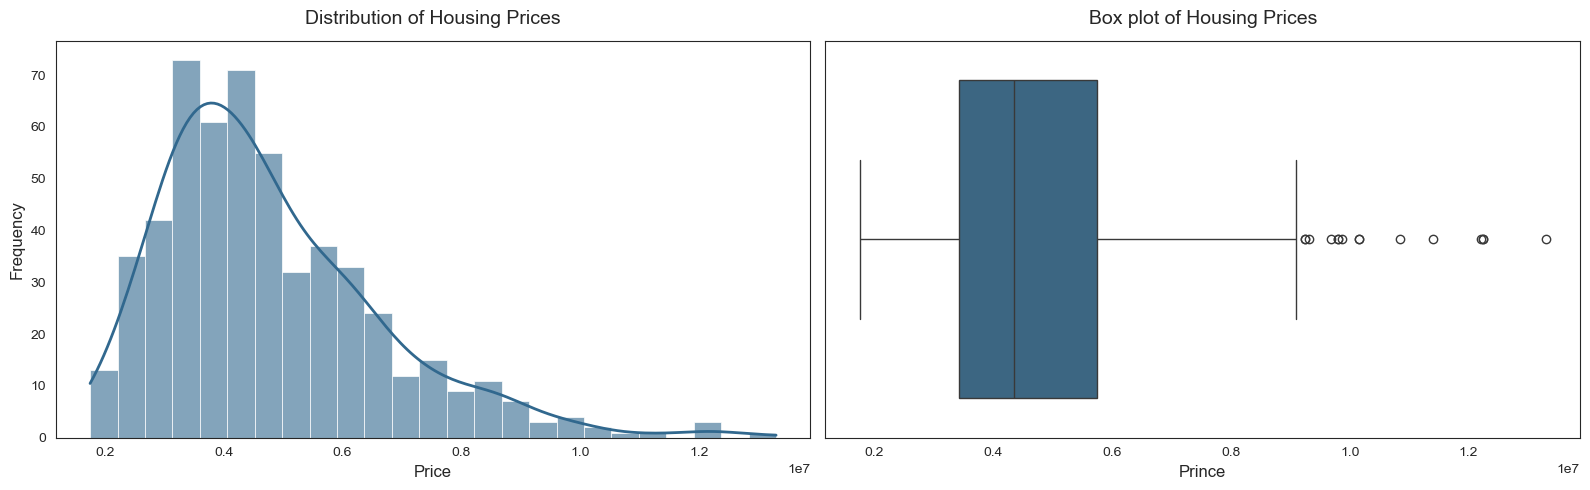

In [9]:
sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
fig, axes = plt.subplots(1,2, figsize=(16,5))

# histograma
hist = sns.histplot(
    df_housing['price'],
    kde=True,
    bins=25,
    ax=axes[0],
    color=palette[0],          
    alpha=0.6,
    edgecolor="white",
    linewidth=0.5,
    line_kws={"linewidth": 2, "color": palette[1]},
    
)
axes[0].set_xlabel("Price", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Distribution of Housing Prices", fontsize=14, pad=12)

box_plot = sns.boxplot(
    x=df_housing['price'],
    color=palette[0],
    ax=axes[1]
)

axes[1].set_title('Box plot of Housing Prices', fontsize=14, pad=12)
axes[1].set_xlabel('Prince', fontsize=12)


plt.tight_layout()
plt.show()

Pelos gráficos gerados acima, nota-se que a variável price que representa o preço dos imóveis apresenta uma distribuição assimétrica à direita, logo a maior parte dos dados está concentrada à esquerda da distribuição com calda longa estendendo-se à direita.
 - A faixa de preço com maior frequência está entre aproximadamente 3 e 4,5 milhores, indicando que essa é faixa mais comum para valores de imóveis no respectivo dataset
 - Existe a presença de valores outliers, valores que podem indicar residências de alto padrão ou alta classificação

obs.: Para a aplicação do modelo, os outliers serão removidos, uma vez que podem distorcer a distribuição dos resíduos e comprometer tanto os testes de normalidade quanto a validade da inferência estatística. Em um primeiro momento, o modelo foi ajustado com a presença dos outliers, mas os resíduos não atenderam aos critérios de normalidade. Diante disso, optou-se pela utilização da técnica do IQR (Intervalo Interquartil) para a identificação e remoção desses valores extremos.



In [10]:
# Top 15 residências mais caras
sup, inf = iqr(df_housing, 'price')
df_housing[df_housing['price'] > sup]

# dataframe sem outliers
df_housing_out = df_housing[(df_housing['price'] < sup) & (df_housing['price'] > inf)]

## Verificando a relação entre o preço e outras variáveis


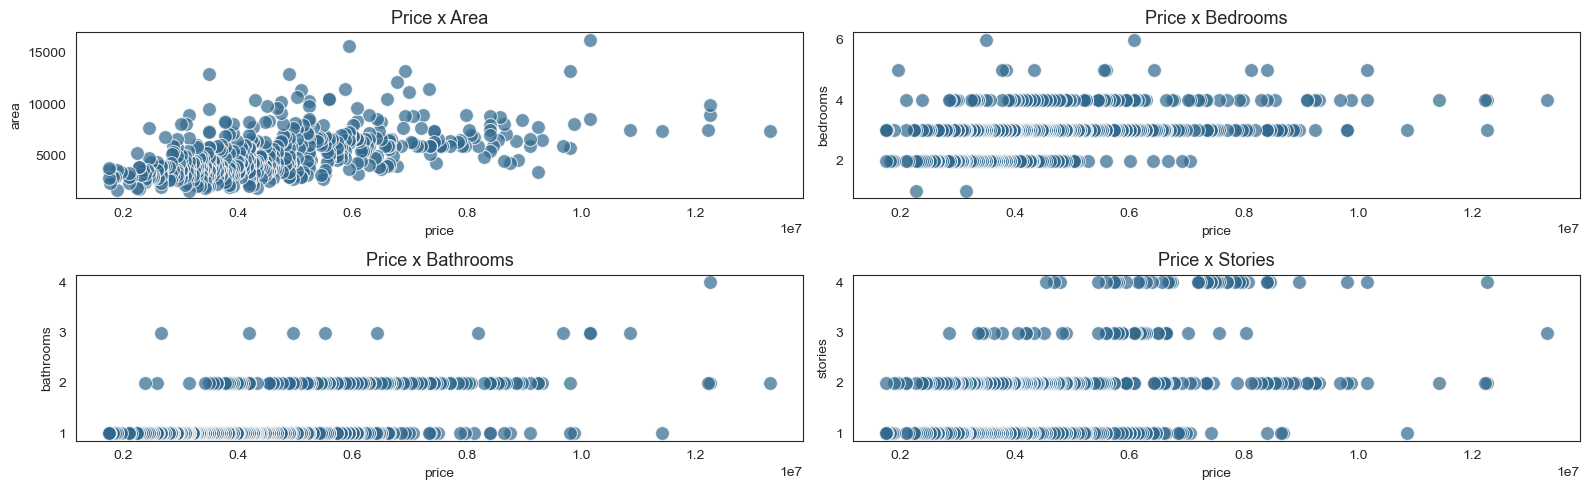

In [11]:
sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
fig,axes = plt.subplots(2,2, figsize=(16,5))

# price x area
sns.scatterplot(x='price', y='area', data=df_housing, s=100, alpha=0.7, ax=axes[0,0], color=palette[0])
axes[0,0].set_title('Price x Area', fontsize=13)

# price x bedrooms
sns.scatterplot(x='price', y='bedrooms', data=df_housing, s=100, alpha=0.7, ax=axes[0,1], color=palette[0])
axes[0,1].set_title('Price x Bedrooms', fontsize=13)

# price x bathrooms
sns.scatterplot(x='price', y='bathrooms', data=df_housing, s=100, alpha=0.7, ax=axes[1,0], color=palette[0])
axes[1,0].set_title('Price x Bathrooms', fontsize=13)

# price x stories
sns.scatterplot(x='price', y='stories', data=df_housing, s=100, alpha=0.7 ,ax=axes[1,1], color=palette[0])
axes[1,1].set_title('Price x Stories', fontsize=13)

plt.tight_layout()
plt.show()

Gráficos:
- Preço x Área: nota-se um padrão ascendente, logo conforme a área aumenta o preço tende a subir.
- Preço x Bathrooms / Bedrooms / Stories: os gráficos se mostram dispersos, sem uma tendência linear clara.

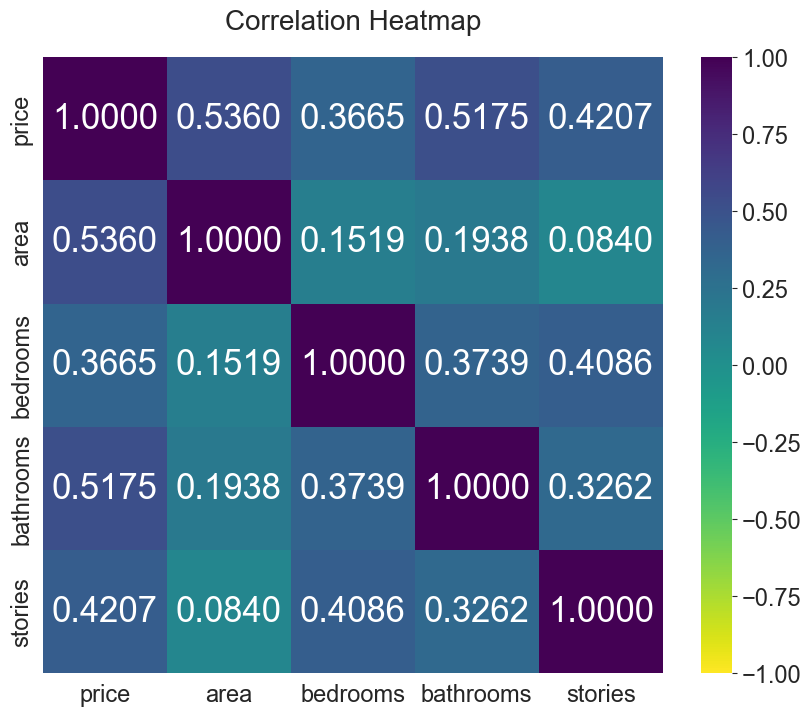

In [12]:
# Correlação entre todas as variáveis quantitativas
correlation_matrix = df_housing[['price', 'area', 'bedrooms', 'bathrooms', 'stories']].corr()


plt.figure(figsize=(10,8))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 25}, vmax=1, vmin=-1)

heatmap.set_title('Correlation Heatmap', fontsize=20, pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(),fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(),fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

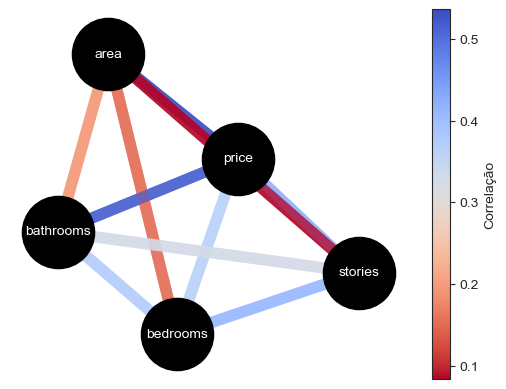

In [13]:
correlation_matrix = df_housing[['price', 'area', 'bedrooms', 'bathrooms', 'stories']].corr()
G = nx.DiGraph()

for variable in correlation_matrix.columns:
    G.add_node(variable)

for i, variable1 in enumerate(correlation_matrix.columns):
    for j, variable2 in enumerate(correlation_matrix.columns):
        if i != j:
            correlation = correlation_matrix.iloc[i,j]
            if abs(correlation)> 0:
                G.add_edge(variable1, variable2, weight=correlation)

correlations = [d['weight'] for _, _, d in G.edges(data=True)]

node_size=2700
node_color = 'black'
cmap = plt.colormaps.get_cmap('coolwarm_r')

edge_widths = [abs(correlation) * 25 for _,_,d in G.edges(data=True)]

pos = nx.spring_layout(G, k=0.75)
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations, edge_cmap=cmap, alpha=0.7)

labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='white')

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

plt.show()

De acordo com o input do dois gráficos gerados acima há correlação entre as variáveis que podem ser descritas como:
- Price x area = correlação moderada de 0,5
- Price x stories = correlação moderada de 0,4

Mesmo que baixa há indicios de correlação entre as variáveis explicativas que farão parte do modelo como em bedrooms x stories e bedrooms x bathrooms será realizado estudo para verificação a presença de multicolinearidade entre as variávei explicativas.

Multicolinearidade ocorre quando duas ou mais variáveis independentes em um modelo de regressão estão altamente correlacionadas entre si. Isso dificulta a estimativa precisa dos coeficientes, tornando os resultados instáveis e comprometendo a interpretação individual de cada variável.

In [14]:
# processo de dummização das variáveis categóricas
df_housing_dummies = pd.get_dummies(df_housing_out,
                                    columns=['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus'],
                                    drop_first= True,
                                    dtype = int)

In [15]:
df_housing_dummies.rename(columns=lambda x: x.replace('-', '_'), inplace=True)
lista_colunas = list(df_housing_dummies.drop(columns=['price']).columns)
modelo = ' + '.join(lista_colunas)

modelo = 'price ~ ' + modelo

reg = modelo_reg(modelo, df_housing_dummies)


In [16]:
print('Parametros do modelo:')
reg.summary()

Parametros do modelo:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     79.38
Date:                Wed, 23 Jul 2025   Prob (F-statistic):          5.94e-114
Time:                        23:52:51   Log-Likelihood:                -8030.4
No. Observations:                 530   AIC:                         1.609e+04
Df Residuals:                     516   BIC:                         1.615e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        4.862e+05    2.4e+05      2.030      0.043    1.56e+04    9.57e+05
area                              217.3561     22.348      9.726      0.000     173.452     261.260
bedrooms                         7.463e+04   6.44e+04      1.158      0.247    -5.2e+04    2.01e+05
bathrooms                        7.776e+05   9.76e+04      7.965      0.000    5.86e+05    9.69e+05
stories                          4.629e+05   5.69e+04      8.138      0.000    3.51e+05    5.75e+05
parking                          2.041e+05   5.24e+04      3.895      0.000    1.01e+05    3.07e+05
mainroad_yes                     4.553e+05   1.25e+05      3.653      0.000     2.1e+05       7e+05
guestroom_yes                    3.602e+05   1.18e+05      3.056      0.002    1.29e+05    5.92e+05
basement_yes                     3.526e+05   9.78e+04      3.607      0.000    1.61e+05    5.45e+05
hotwaterheating_yes              7.386e+05   2.02e+05      3.657      0.000    3.42e+05    1.14e+06
airconditioning_yes               8.27e+05   9.59e+04      8.627      0.000    6.39e+05    1.02e+06
prefarea_yes                     4.879e+05   1.04e+05      4.691      0.000    2.84e+05    6.92e+05
furnishingstatus_semi_furnished  1.269e+04   1.04e+05      0.122      0.903   -1.91e+05    2.17e+05
furnishingstatus_unfurnished    -3.687e+05   1.12e+05     -3.300      0.001   -5.88e+05   -1.49e+05
==============================================================================
Omnibus:                       45.882   Durbin-Watson:                   1.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.431
Skew:                           0.566   Prob(JB):                     5.65e-18
Kurtosis:                       4.522   Cond. No.                     3.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Insights Modelo inicial
- R²: indica que 66,7% da variância da variável predita é explicado pelo comportamento das variáveis preditoras
- P - F-Statistic < 0,05, logo pode-se afirmar que existe modelo
- T-Statistic: avalia individualmente cada variável para definir se é estatísticamente signigicante para o modelo, P-valor > 0.05 podemos afirmar que o parâmetro não é significante para o modelo. No modelo inicial nota-se que a variável furnishingstatus_semi_furnished e bedrooms não se mostraram significantes.

In [17]:
# Aplicando Step-Wise para remoção das variáveis não significantes
reg_step = stepwise(reg, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 price ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_semi_furnished') + Q('furnishingstatus_unfurnished')



 Discarding atribute "Q('furnishingstatus_semi_furnished')" with p-value equal to 0.9028975842319044 

Estimating model...: 
 price ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_unfurnished')

 Discarding atribute "Q('bedrooms')" with p-value equal to 0.24549545562571018 

Estimating model...: 
 price ~ Q('area') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_unfurnished')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('furnishingstatus_semi_furnished')", 'p-value': 0.9028975842319044}
{'atribute': "Q('bedrooms')", 'p-value': 0.24549545562571018}

 Model after stepwise process...: 
 pric

In [18]:
# Verificação do termos de erros a normalidade com o teste Shapiro-Francia
shapiro_test(reg_step)

method  :  Shapiro-Francia normality test
statistics W  :  0.9749605546166141
statistics z  :  4.9609237389409735
p-value  :  3.5079367145209855e-07
Statistics_W=0.97496, p-value=0.000000
Rejeita-se H0 - Distribuição não aderente à normalidade


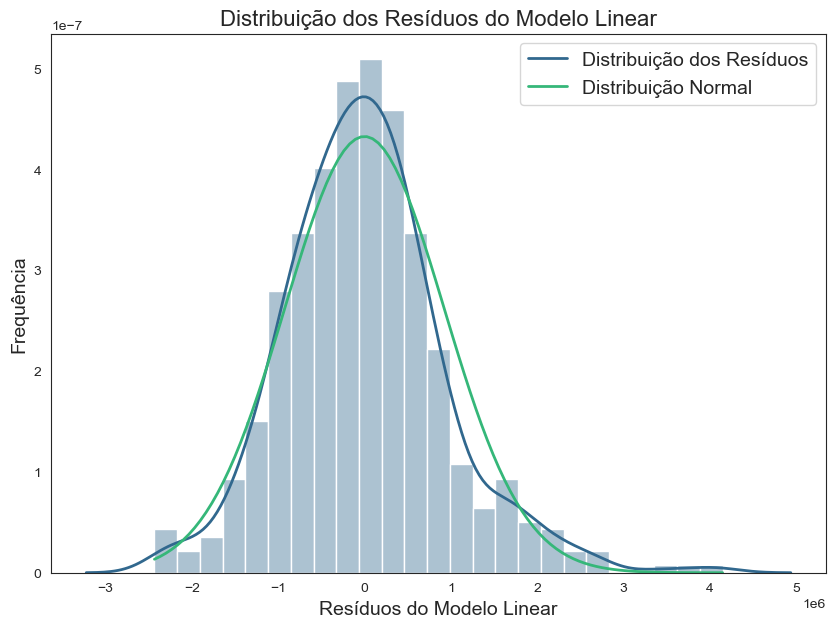

In [19]:
(mu, sigma) = norm.fit(reg_step.resid)

sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
plt.figure(figsize=(10,7))
sns.histplot(reg_step.resid, color=palette[0], stat='density', alpha=0.4)
sns.kdeplot(reg_step.resid, color=palette[0], linewidth=2, label='Distribuição dos Resíduos')
x= np.linspace(min(reg_step.resid), max(reg_step.resid), 100)
plt.plot(x, norm.pdf(x, mu, sigma), color=palette[1], linewidth=2, label='Distribuição Normal')
plt.legend(fontsize=14)
plt.xlabel('Resíduos do Modelo Linear', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.title('Distribuição dos Resíduos do Modelo Linear', fontsize=16)
plt.show()

A distribuição dos resíduos, juntamente com o resultado do teste de Shapiro-Francia, indica que os resíduos do modelo não seguem uma distribuição normal. Diante disso, será aplicada a transformação de Box-Cox à variável price, com o objetivo de aproximar a distribuição dos resíduos da normalidade.

In [20]:
# Transformação Box-Cox
yast, lmbda = boxcox(df_housing_dummies['price'])

df_housing_dummies['price_bc'] = yast
del df_housing_dummies['price']

In [21]:
# Aplicando o novo modelo com a variável transformada
lista_colunas = list(df_housing_dummies.drop(columns=['price_bc']).columns)
modelo = ' + '.join(lista_colunas)
modelo = 'price_bc ~ ' + modelo

modelo_bc = modelo_reg(modelo, df_housing_dummies)

In [22]:
modelo_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               price_bc   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     81.32
Date:                Wed, 23 Jul 2025   Prob (F-statistic):          9.72e-116
Time:                        23:52:54   Log-Likelihood:                -589.30
No. Observations:                 530   AIC:                             1207.
Df Residuals:                     516   BIC:                             1266.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          28.2833      0.191    147.790      0.000      27.907      28.659
area                                0.0002   1.79e-05      9.920      0.000       0.000       0.000
bedrooms                            0.0864      0.051      1.677      0.094      -0.015       0.188
bathrooms                           0.5596      0.078      7.174      0.000       0.406       0.713
stories                             0.3468      0.045      7.631      0.000       0.258       0.436
parking                             0.1466      0.042      3.501      0.001       0.064       0.229
mainroad_yes                        0.4335      0.100      4.354      0.000       0.238       0.629
guestroom_yes                       0.2686      0.094      2.852      0.005       0.084       0.454
basement_yes                        0.3349      0.078      4.287      0.000       0.181       0.488
hotwaterheating_yes                 0.5375      0.161      3.331      0.001       0.220       0.855
airconditioning_yes                 0.6420      0.077      8.382      0.000       0.492       0.793
prefarea_yes                        0.4126      0.083      4.966      0.000       0.249       0.576
furnishingstatus_semi_furnished     0.0837      0.083      1.008      0.314      -0.079       0.247
furnishingstatus_unfurnished       -0.3816      0.089     -4.274      0.000      -0.557      -0.206
==============================================================================
Omnibus:                        3.837   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                4.303
Skew:                          -0.078   Prob(JB):                        0.116
Kurtosis:                       3.413   Cond. No.                     3.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
reg_step_bc = stepwise(modelo_bc, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 price_bc ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_semi_furnished') + Q('furnishingstatus_unfurnished')

 Discarding atribute "Q('furnishingstatus_semi_furnished')" with p-value equal to 0.3137183637750116 

Estimating model...: 
 price_bc ~ Q('area') + Q('bedrooms') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('airconditioning_yes') + Q('prefarea_yes') + Q('furnishingstatus_unfurnished')

 Discarding atribute "Q('bedrooms')" with p-value equal to 0.08909705674381414 

Estimating model...: 
 price_bc ~ Q('area') + Q('bathrooms') + Q('stories') + Q('parking') + Q('mainroad_yes') + Q('guestroom_yes') + Q('basement_yes') + Q('hotwaterheating_yes') + Q('aircondition

Ao realizar o processo de step-wise no modelo box-cox nota-se a permanência da variável bedrooms(Número de quartos) não presente no modelo inicial



In [24]:
# Verificação do termos de erros a normalidade com o teste Shapiro-Francia
shapiro_test(reg_step_bc)

method  :  Shapiro-Francia normality test
statistics W  :  0.9944890711599355
statistics z  :  1.6278188283978774
p-value  :  0.05178165347341038
Statistics_W=0.99449, p-value=0.051782
Não se rejeita H0 - Distribuição aderente à normalidade


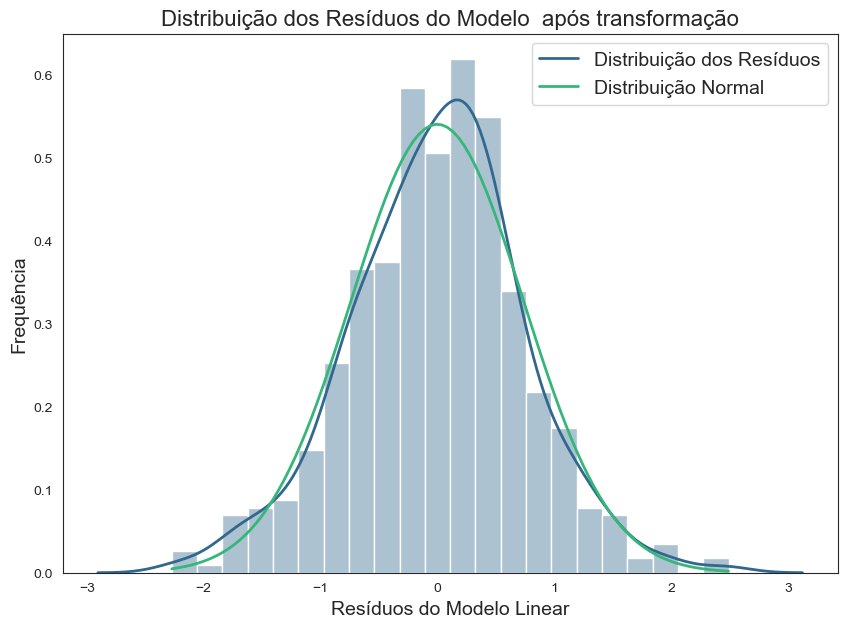

In [25]:
(mu, sigma) = norm.fit(reg_step_bc.resid)

sns.set_style('white')
palette = sns.color_palette("viridis", 2)  
plt.figure(figsize=(10,7))
sns.histplot(reg_step_bc.resid, color=palette[0], stat='density', alpha=0.4)
sns.kdeplot(reg_step_bc.resid, color=palette[0], linewidth=2, label='Distribuição dos Resíduos')
x= np.linspace(min(reg_step_bc.resid), max(reg_step_bc.resid), 100)
plt.plot(x, norm.pdf(x, mu, sigma), color=palette[1], linewidth=2, label='Distribuição Normal')
plt.legend(fontsize=14)
plt.xlabel('Resíduos do Modelo Linear', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.title('Distribuição dos Resíduos do Modelo  após transformação', fontsize=16)
plt.show()

A análise da distribuição dos resíduos e o teste de Shapiro-Francia mostraram que eles não seguem uma distribuição normal. Para tentar resolver isso, foi aplicada a transformação de Box-Cox na variável price, buscando estabilizar a variância e melhorar a normalidade dos resíduos. Porém, mesmo após a transformação, os resíduos continuaram não aderindo à normalidade.

In [26]:
# Comparação entre os modelos
summary_col([reg_step, reg_step_bc],
            model_names=["STEPWISE","STEPWISE BOX-COX"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs))
        })

,STEPWISE,STEPWISE BOX-COX
Intercept,644899.0050***,28.5228***
,(185389.0275),(0.1485)
Q('area'),218.8513***,0.0002***
,(22.2789),(0.0000)
Q('bathrooms'),801009.9940***,0.5841***
,(95252.5245),(0.0763)
Q('stories'),486452.3554***,0.3737***
,(53062.4565),(0.0425)
Q('parking'),208534.7572***,0.1514***
,(52235.3539),(0.0418)


In [27]:
# salvando os fitted values
df_housing_out['yhat_modelo_bc'] = round((reg_step_bc.fittedvalues * lmbda +1) ** (1/ lmbda),2)


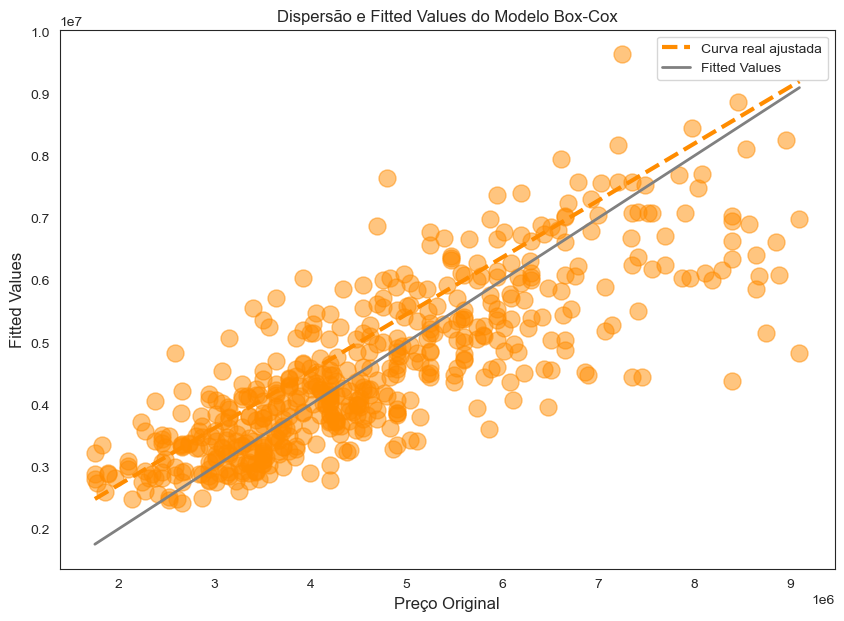

In [28]:
x_data = df_housing_out['price']
y_data = df_housing_out['yhat_modelo_bc']

plt.figure(figsize=(10,7))

popt, _ = curve_fit(objective, x_data, y_data)
a,b,c,d,e,f = popt
x_line = np.arange(min(x_data), max(x_data), 1)
y_line = objective(x_line, a, b, c, d, e, f)
plt.plot(x_line, y_line, '--', color='darkorange', linewidth=3, label='Curva real ajustada')

plt.plot(x_data,x_data, color='gray', linestyle='-', label='Fitted Values', linewidth=2)
plt.scatter(x_data,y_data, alpha=0.5, s=150, color='darkorange')
plt.title('Dispersão e Fitted Values do Modelo Box-Cox', fontsize=12)
plt.xlabel('Preço Original', fontsize=12)
plt.ylabel('Fitted Values', fontsize=12)
plt.legend()
plt.show()

In [29]:
# Teste de multicolinearidade
vif_data = pd.DataFrame()
vif_data["feature"] = df_housing_dummies.drop(columns=['price_bc']).columns
vif_data["VIF"] = [variance_inflation_factor(df_housing_dummies.drop(columns=['price_bc']).values, i) for i in range(len(vif_data["feature"]))]
vif_data.sort_values(by='VIF', ascending=False, inplace=True)
print(vif_data)


                            feature        VIF
1                          bedrooms  16.807449
2                         bathrooms   9.864603
0                              area   8.379515
3                           stories   7.753724
5                      mainroad_yes   6.813814
11  furnishingstatus_semi_furnished   2.429410
12     furnishingstatus_unfurnished   2.039940
7                      basement_yes   2.008344
4                           parking   1.910532
9               airconditioning_yes   1.705877
6                     guestroom_yes   1.480199
10                     prefarea_yes   1.460729
8               hotwaterheating_yes   1.077818


In [30]:
teste_bp = breusch_pagan_test(reg_step_bc)
chisq, p = teste_bp
alpha = 0.05 #nível de significância
if p > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade')
else:
	print('Rejeita-se H0 - Existência de Heterocedasticidade')

chisq: 0.4875976258811433
p-value: 0.8954241248881699
Não se rejeita H0 - Ausência de Heterocedasticidade
